<a href="https://colab.research.google.com/github/Justin-Jonany/SciDigest/blob/main/4_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SciDigest**
With the growth of many fields, more papers are published annually. Researchers need to find sources for their research, so abstracts are really helpful. However, reading through hundreds of unstructured abstracts is time-consuming and irritating.

**SciDigest** is a deep learning model that aims to help people, especially researchers, to digest abstracts better. This model receives abstracts as inputs and turn it into a structured abstract.

**SciDigest** will be trained on [PubMed 200k and 20k RCT dataset](https://github.com/Franck-Dernoncourt/pubmed-rct).

Some of the model architecture will be referenced and based on:
* [Paper 1](https://arxiv.org/pdf/1710.06071.pdf)
* [Paper 2](https://arxiv.org/pdf/1612.05251.pdf)

**Note:**
Through this notebook and other notebooks, these papers will be referred as **[Paper 1](https://arxiv.org/pdf/1710.06071.pdf)** and **[Paper 2](https://arxiv.org/pdf/1612.05251.pdf)**

## Goal
The goal of this project:
1. Replicate the model architecture in **Paper 2**
2. Beat the F1-Score of the model in **Paper 1**, that is **91.6**


## Notebook Goal
This notebook aims to:
1. Evaluate all the models created on the test data and see if it beats the project goal

## Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_hub as hub
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import itertools
from itertools import cycle, islice
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import string
import pickle

## Helper Function

In [ ]:
def get_data(data_path, data, data_types, to_list=False):
  '''
  Returns a list of dataframes from the directory data_path + data for all
  types of data (train/val/test) listed in data_types. If to_list is True,
  it will be returned as a list, otherwise it's a DataFrame.
  '''

  if to_list:
    return [pd.read_csv(os.path.join(data_path, data, data_type + '.csv'), index_col=0)['0'].tolist() for data_type in data_types]
  else:
    return [pd.read_csv(os.path.join(data_path, data, data_type + '.csv'), index_col=0) for data_type in data_types]

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

def predict_data(model, data):
  '''
  Predicts data with model and returns the predicted class

  Args:
    model: a machine learning model
    data: batched dataset
  Returns:
    prediction: predicted class
  '''
  prediction = model.predict(data, verbose=0)
  prediction = tf.argmax(prediction, axis=1)
  return prediction

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()
  ax.tick_params(axis='x', labelrotation=45)


  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
  return fig;

## Loading Data

In [ ]:
data_path = '/content/drive/MyDrive/ColabNotebooks/projects/SciDigest/data'
datas = os.listdir(data_path)
datas

['general',
 'sentences',
 'sentences_chars',
 'ohe_labels',
 'le_labels',
 'line_numbers',
 'total_lines',
 'general_200k',
 'sentences_200k',
 'sentences_chars_200k',
 'le_labels_200k',
 'line_numbers_200k',
 'total_lines_200k',
 'ohe_labels_200k']

In [ ]:
data_types = ['test']

In [ ]:
test_general = get_data(data_path, 'general_200k', data_types)[0]
test_sentences = get_data(data_path, 'sentences_200k', data_types, to_list=True)[0]
test_sentences_chars = get_data(data_path, 'sentences_chars_200k', data_types)[0]
test_ohe_labels = get_data(data_path, 'ohe_labels_200k', data_types)[0]
test_le_labels = get_data(data_path, 'le_labels_200k', data_types, to_list=True)[0]
test_line_numbers = get_data(data_path, 'line_numbers_200k', data_types)[0]
test_total_lines = get_data(data_path, 'total_lines_200k', data_types)[0]

In [ ]:
MODEL_PATH = '/content/drive/MyDrive/ColabNotebooks/projects/SciDigest/models/'

In [ ]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(test_general.target.unique())
class_names = test_general.target.unique()

num_classes, class_names

(5,
 array(['BACKGROUND', 'METHODS', 'RESULTS', 'CONCLUSIONS', 'OBJECTIVE'],
       dtype=object))

## Load Models

In [ ]:
filename = MODEL_PATH + 'model_0.sav'
model_0 = pickle.load(open(filename, 'rb'))
model_1 = tf.keras.models.load_model(MODEL_PATH + 'model_1')
model_2 = tf.keras.models.load_model(MODEL_PATH + 'model_2')
model_3 = tf.keras.models.load_model(MODEL_PATH + 'model_3')
model_4 = tf.keras.models.load_model(MODEL_PATH + 'model_4')
model_5 = tf.keras.models.load_model(MODEL_PATH + 'model_5')
model_6 = tf.keras.models.load_model(MODEL_PATH + 'model_6')
model_6_leaky = tf.keras.models.load_model(MODEL_PATH + 'model_6_leaky')
model_7 = tf.keras.models.load_model(MODEL_PATH + 'model_7')
model_8 = tf.keras.models.load_model(MODEL_PATH + 'model_8')

## Evaluate

In [ ]:
results = []

### Model 0

In [ ]:
model_0_results = calculate_results(y_true=test_le_labels, y_pred=model_0.predict(test_sentences))
model_0_results

{'accuracy': 73.28518631539687,
 'precision': 0.7330071289724189,
 'recall': 0.7328518631539688,
 'f1': 0.7098095979383332}

In [ ]:
results.append(model_0_results)
results

[{'accuracy': 73.28518631539687,
  'precision': 0.7330071289724189,
  'recall': 0.7328518631539688,
  'f1': 0.7098095979383332}]

### Model 1 and Model 2

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_ohe_labels)).batch(32).prefetch(tf.data.AUTOTUNE).cache()

In [ ]:
model_1_preds = predict_data(model_1, test_dataset)
model_1_results = calculate_results(y_true=test_le_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 81.50069508018852,
 'precision': 0.8115314544968879,
 'recall': 0.8150069508018852,
 'f1': 0.8116601376624917}

In [ ]:
results.append(model_1_results)
results

[{'accuracy': 73.28518631539687,
  'precision': 0.7330071289724189,
  'recall': 0.7328518631539688,
  'f1': 0.7098095979383332},
 {'accuracy': 81.50069508018852,
  'precision': 0.8115314544968879,
  'recall': 0.8150069508018852,
  'f1': 0.8116601376624917}]

In [ ]:
model_2_preds = predict_data(model_2, test_dataset)
model_2_results = calculate_results(y_true=test_le_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 75.32973926016344,
 'precision': 0.749785265495381,
 'recall': 0.7532973926016343,
 'f1': 0.7496508190913701}

In [ ]:
results.append(model_2_results)
results

[{'accuracy': 73.28518631539687,
  'precision': 0.7330071289724189,
  'recall': 0.7328518631539688,
  'f1': 0.7098095979383332},
 {'accuracy': 81.50069508018852,
  'precision': 0.8115314544968879,
  'recall': 0.8150069508018852,
  'f1': 0.8116601376624917},
 {'accuracy': 75.32973926016344,
  'precision': 0.749785265495381,
  'recall': 0.7532973926016343,
  'f1': 0.7496508190913701}]

### Model 3

In [ ]:
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_sentences_chars, test_ohe_labels)).batch(32).prefetch(tf.data.AUTOTUNE).cache()

In [ ]:
model_3_preds = predict_data(model_3, test_char_dataset)
model_3_results = calculate_results(y_true=test_le_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 70.28108364696708,
 'precision': 0.6970741422752219,
 'recall': 0.7028108364696708,
 'f1': 0.6963557666101852}

In [ ]:
results.append(model_3_results)
results

[{'accuracy': 73.28518631539687,
  'precision': 0.7330071289724189,
  'recall': 0.7328518631539688,
  'f1': 0.7098095979383332},
 {'accuracy': 81.50069508018852,
  'precision': 0.8115314544968879,
  'recall': 0.8150069508018852,
  'f1': 0.8116601376624917},
 {'accuracy': 75.32973926016344,
  'precision': 0.749785265495381,
  'recall': 0.7532973926016343,
  'f1': 0.7496508190913701},
 {'accuracy': 70.28108364696708,
  'precision': 0.6970741422752219,
  'recall': 0.7028108364696708,
  'f1': 0.6963557666101852}]

### Model 4

In [ ]:
# Combine chars and tokens into a dataset
test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_sentences_chars)) # make data
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_ohe_labels) # make labels
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_labels)) # combine data and labels

# Prefetch and batch train data
test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE).cache()

In [ ]:
model_4_preds = predict_data(model_4, test_char_token_dataset)
model_4_results = calculate_results(y_true=test_le_labels,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 77.3471671244024,
 'precision': 0.7728887550591835,
 'recall': 0.773471671244024,
 'f1': 0.7700710218875824}

In [ ]:
results.append(model_4_results)
results

[{'accuracy': 73.28518631539687,
  'precision': 0.7330071289724189,
  'recall': 0.7328518631539688,
  'f1': 0.7098095979383332},
 {'accuracy': 81.50069508018852,
  'precision': 0.8115314544968879,
  'recall': 0.8150069508018852,
  'f1': 0.8116601376624917},
 {'accuracy': 75.32973926016344,
  'precision': 0.749785265495381,
  'recall': 0.7532973926016343,
  'f1': 0.7496508190913701},
 {'accuracy': 70.28108364696708,
  'precision': 0.6970741422752219,
  'recall': 0.7028108364696708,
  'f1': 0.6963557666101852},
 {'accuracy': 77.3471671244024,
  'precision': 0.7728887550591835,
  'recall': 0.773471671244024,
  'f1': 0.7700710218875824}]

### Model 5, 6, 7, & 8

In [ ]:
test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((test_line_numbers,
                                                                test_total_lines,
                                                                test_sentences,
                                                                test_sentences_chars
                                                                ))
test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_ohe_labels)
test_char_token_pos_dataset = tf.data.Dataset.zip((test_char_token_pos_data, test_char_token_pos_labels))
test_char_token_pos_dataset = test_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE).cache()

In [ ]:
model_5_preds = predict_data(model_5, test_char_token_pos_dataset)
model_5_results = calculate_results(y_true=test_le_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 84.78282982402604,
 'precision': 0.8497944827842767,
 'recall': 0.8478282982402604,
 'f1': 0.8455932844330678}

In [ ]:
results.append(model_5_results)
results

[{'accuracy': 73.28518631539687,
  'precision': 0.7330071289724189,
  'recall': 0.7328518631539688,
  'f1': 0.7098095979383332},
 {'accuracy': 81.50069508018852,
  'precision': 0.8115314544968879,
  'recall': 0.8150069508018852,
  'f1': 0.8116601376624917},
 {'accuracy': 75.32973926016344,
  'precision': 0.749785265495381,
  'recall': 0.7532973926016343,
  'f1': 0.7496508190913701},
 {'accuracy': 70.28108364696708,
  'precision': 0.6970741422752219,
  'recall': 0.7028108364696708,
  'f1': 0.6963557666101852},
 {'accuracy': 77.3471671244024,
  'precision': 0.7728887550591835,
  'recall': 0.773471671244024,
  'f1': 0.7700710218875824},
 {'accuracy': 84.78282982402604,
  'precision': 0.8497944827842767,
  'recall': 0.8478282982402604,
  'f1': 0.8455932844330678}]

In [ ]:
model_6_preds = predict_data(model_6, test_char_token_pos_dataset)
model_6_results = calculate_results(y_true=test_le_labels,
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 86.7426168921439,
 'precision': 0.8704614390808467,
 'recall': 0.867426168921439,
 'f1': 0.8655067036246866}

In [ ]:
results.append(model_6_results)
results

[{'accuracy': 73.28518631539687,
  'precision': 0.7330071289724189,
  'recall': 0.7328518631539688,
  'f1': 0.7098095979383332},
 {'accuracy': 81.50069508018852,
  'precision': 0.8115314544968879,
  'recall': 0.8150069508018852,
  'f1': 0.8116601376624917},
 {'accuracy': 75.32973926016344,
  'precision': 0.749785265495381,
  'recall': 0.7532973926016343,
  'f1': 0.7496508190913701},
 {'accuracy': 70.28108364696708,
  'precision': 0.6970741422752219,
  'recall': 0.7028108364696708,
  'f1': 0.6963557666101852},
 {'accuracy': 77.3471671244024,
  'precision': 0.7728887550591835,
  'recall': 0.773471671244024,
  'f1': 0.7700710218875824},
 {'accuracy': 84.78282982402604,
  'precision': 0.8497944827842767,
  'recall': 0.8478282982402604,
  'f1': 0.8455932844330678},
 {'accuracy': 86.7426168921439,
  'precision': 0.8704614390808467,
  'recall': 0.867426168921439,
  'f1': 0.8655067036246866}]

In [ ]:
model_6_leaky_preds = predict_data(model_6_leaky, test_char_token_pos_dataset)
model_6_leaky_results = calculate_results(y_true=test_le_labels,
                                    y_pred=model_6_leaky_preds)
model_6_leaky_results

{'accuracy': 86.69514800122062,
 'precision': 0.8687164972906899,
 'recall': 0.8669514800122062,
 'f1': 0.8651117350133496}

In [ ]:
results.append(model_6_leaky_results)
results

[{'accuracy': 73.28518631539687,
  'precision': 0.7330071289724189,
  'recall': 0.7328518631539688,
  'f1': 0.7098095979383332},
 {'accuracy': 81.50069508018852,
  'precision': 0.8115314544968879,
  'recall': 0.8150069508018852,
  'f1': 0.8116601376624917},
 {'accuracy': 75.32973926016344,
  'precision': 0.749785265495381,
  'recall': 0.7532973926016343,
  'f1': 0.7496508190913701},
 {'accuracy': 70.28108364696708,
  'precision': 0.6970741422752219,
  'recall': 0.7028108364696708,
  'f1': 0.6963557666101852},
 {'accuracy': 77.3471671244024,
  'precision': 0.7728887550591835,
  'recall': 0.773471671244024,
  'f1': 0.7700710218875824},
 {'accuracy': 84.78282982402604,
  'precision': 0.8497944827842767,
  'recall': 0.8478282982402604,
  'f1': 0.8455932844330678},
 {'accuracy': 86.7426168921439,
  'precision': 0.8704614390808467,
  'recall': 0.867426168921439,
  'f1': 0.8655067036246866},
 {'accuracy': 86.69514800122062,
  'precision': 0.8687164972906899,
  'recall': 0.8669514800122062,
  

In [ ]:
model_7_preds = predict_data(model_7, test_char_token_pos_dataset)
model_7_results = calculate_results(y_true=test_le_labels,
                                    y_pred=model_7_preds)
model_7_results

{'accuracy': 86.90875801037534,
 'precision': 0.8698875796555066,
 'recall': 0.8690875801037534,
 'f1': 0.8670273604604516}

In [ ]:
results.append(model_7_results)
results

[{'accuracy': 73.28518631539687,
  'precision': 0.7330071289724189,
  'recall': 0.7328518631539688,
  'f1': 0.7098095979383332},
 {'accuracy': 81.50069508018852,
  'precision': 0.8115314544968879,
  'recall': 0.8150069508018852,
  'f1': 0.8116601376624917},
 {'accuracy': 75.32973926016344,
  'precision': 0.749785265495381,
  'recall': 0.7532973926016343,
  'f1': 0.7496508190913701},
 {'accuracy': 70.28108364696708,
  'precision': 0.6970741422752219,
  'recall': 0.7028108364696708,
  'f1': 0.6963557666101852},
 {'accuracy': 77.3471671244024,
  'precision': 0.7728887550591835,
  'recall': 0.773471671244024,
  'f1': 0.7700710218875824},
 {'accuracy': 84.78282982402604,
  'precision': 0.8497944827842767,
  'recall': 0.8478282982402604,
  'f1': 0.8455932844330678},
 {'accuracy': 86.7426168921439,
  'precision': 0.8704614390808467,
  'recall': 0.867426168921439,
  'f1': 0.8655067036246866},
 {'accuracy': 86.69514800122062,
  'precision': 0.8687164972906899,
  'recall': 0.8669514800122062,
  

In [ ]:
model_8_preds = predict_data(model_8, test_char_token_pos_dataset)
model_8_results = calculate_results(y_true=test_le_labels,
                                    y_pred=model_8_preds)
model_8_results

{'accuracy': 89.16692096429661,
 'precision': 0.8922472223989127,
 'recall': 0.8916692096429661,
 'f1': 0.8901948619423501}

In [ ]:
results.append(model_8_results)
results

[{'accuracy': 73.28518631539687,
  'precision': 0.7330071289724189,
  'recall': 0.7328518631539688,
  'f1': 0.7098095979383332},
 {'accuracy': 81.50069508018852,
  'precision': 0.8115314544968879,
  'recall': 0.8150069508018852,
  'f1': 0.8116601376624917},
 {'accuracy': 75.32973926016344,
  'precision': 0.749785265495381,
  'recall': 0.7532973926016343,
  'f1': 0.7496508190913701},
 {'accuracy': 70.28108364696708,
  'precision': 0.6970741422752219,
  'recall': 0.7028108364696708,
  'f1': 0.6963557666101852},
 {'accuracy': 77.3471671244024,
  'precision': 0.7728887550591835,
  'recall': 0.773471671244024,
  'f1': 0.7700710218875824},
 {'accuracy': 84.78282982402604,
  'precision': 0.8497944827842767,
  'recall': 0.8478282982402604,
  'f1': 0.8455932844330678},
 {'accuracy': 86.7426168921439,
  'precision': 0.8704614390808467,
  'recall': 0.867426168921439,
  'f1': 0.8655067036246866},
 {'accuracy': 86.69514800122062,
  'precision': 0.8687164972906899,
  'recall': 0.8669514800122062,
  

In [ ]:
scores = pd.DataFrame({'model_0': model_0_results,
                         'model_1': model_1_results,
                         'model_2': model_2_results,
                         'model_3': model_3_results,
                         'model_4': model_4_results,
                         'model_5': model_5_results,
                         'model_6': model_6_results,
                         'model_6_leaky': model_6_leaky_results,
                         'model_7': model_7_results,
                         'model_8': model_8_results
                         }, index=['accuracy', 'precision', 'recall', 'f1'])
scores = scores.T
scores['Models'] = scores.index
scores = scores.reset_index(drop=True)
scores = scores[['Models', 'accuracy', 'precision', 'recall', 'f1']]
scores

,Models,accuracy,precision,recall,f1
0,model_0,73.285186,0.733007,0.732852,0.709810
1,model_1,81.500695,0.811531,0.815007,0.811660
2,model_2,75.329739,0.749785,0.753297,0.749651
3,model_3,70.281084,0.697074,0.702811,0.696356
4,model_4,77.347167,0.772889,0.773472,0.770071
5,model_5,84.782830,0.849794,0.847828,0.845593
6,model_6,86.742617,0.870461,0.867426,0.865507
7,model_6_leaky,86.695148,0.868716,0.866951,0.865112
8,model_7,86.908758,0.869888,0.869088,0.867027
9,model_8,89.166921,0.892247,0.891669,0.890195


In [ ]:
parent_dir = '/content/drive/MyDrive/ColabNotebooks/projects/SciDigest/'

In [ ]:
scores.to_csv(parent_dir + 'model_scores.csv', index=False)

In [ ]:
scores = pd.read_csv(parent_dir + 'model_scores.csv')
scores.set_index('Models', inplace=True)
scores

,accuracy,precision,recall,f1
Models,,,,
model_0,73.285186,0.733007,0.732852,0.709810
model_1,81.500695,0.811531,0.815007,0.811660
model_2,75.329739,0.749785,0.753297,0.749651
model_3,70.281084,0.697074,0.702811,0.696356
model_4,77.347167,0.772889,0.773472,0.770071
model_5,84.782830,0.849794,0.847828,0.845593
model_6,86.742617,0.870461,0.867426,0.865507
model_6_leaky,86.695148,0.868716,0.866951,0.865112
model_7,86.908758,0.869888,0.869088,0.867027


In [ ]:
FIG_PATH = '/content/drive/MyDrive/ColabNotebooks/projects/SciDigest/'

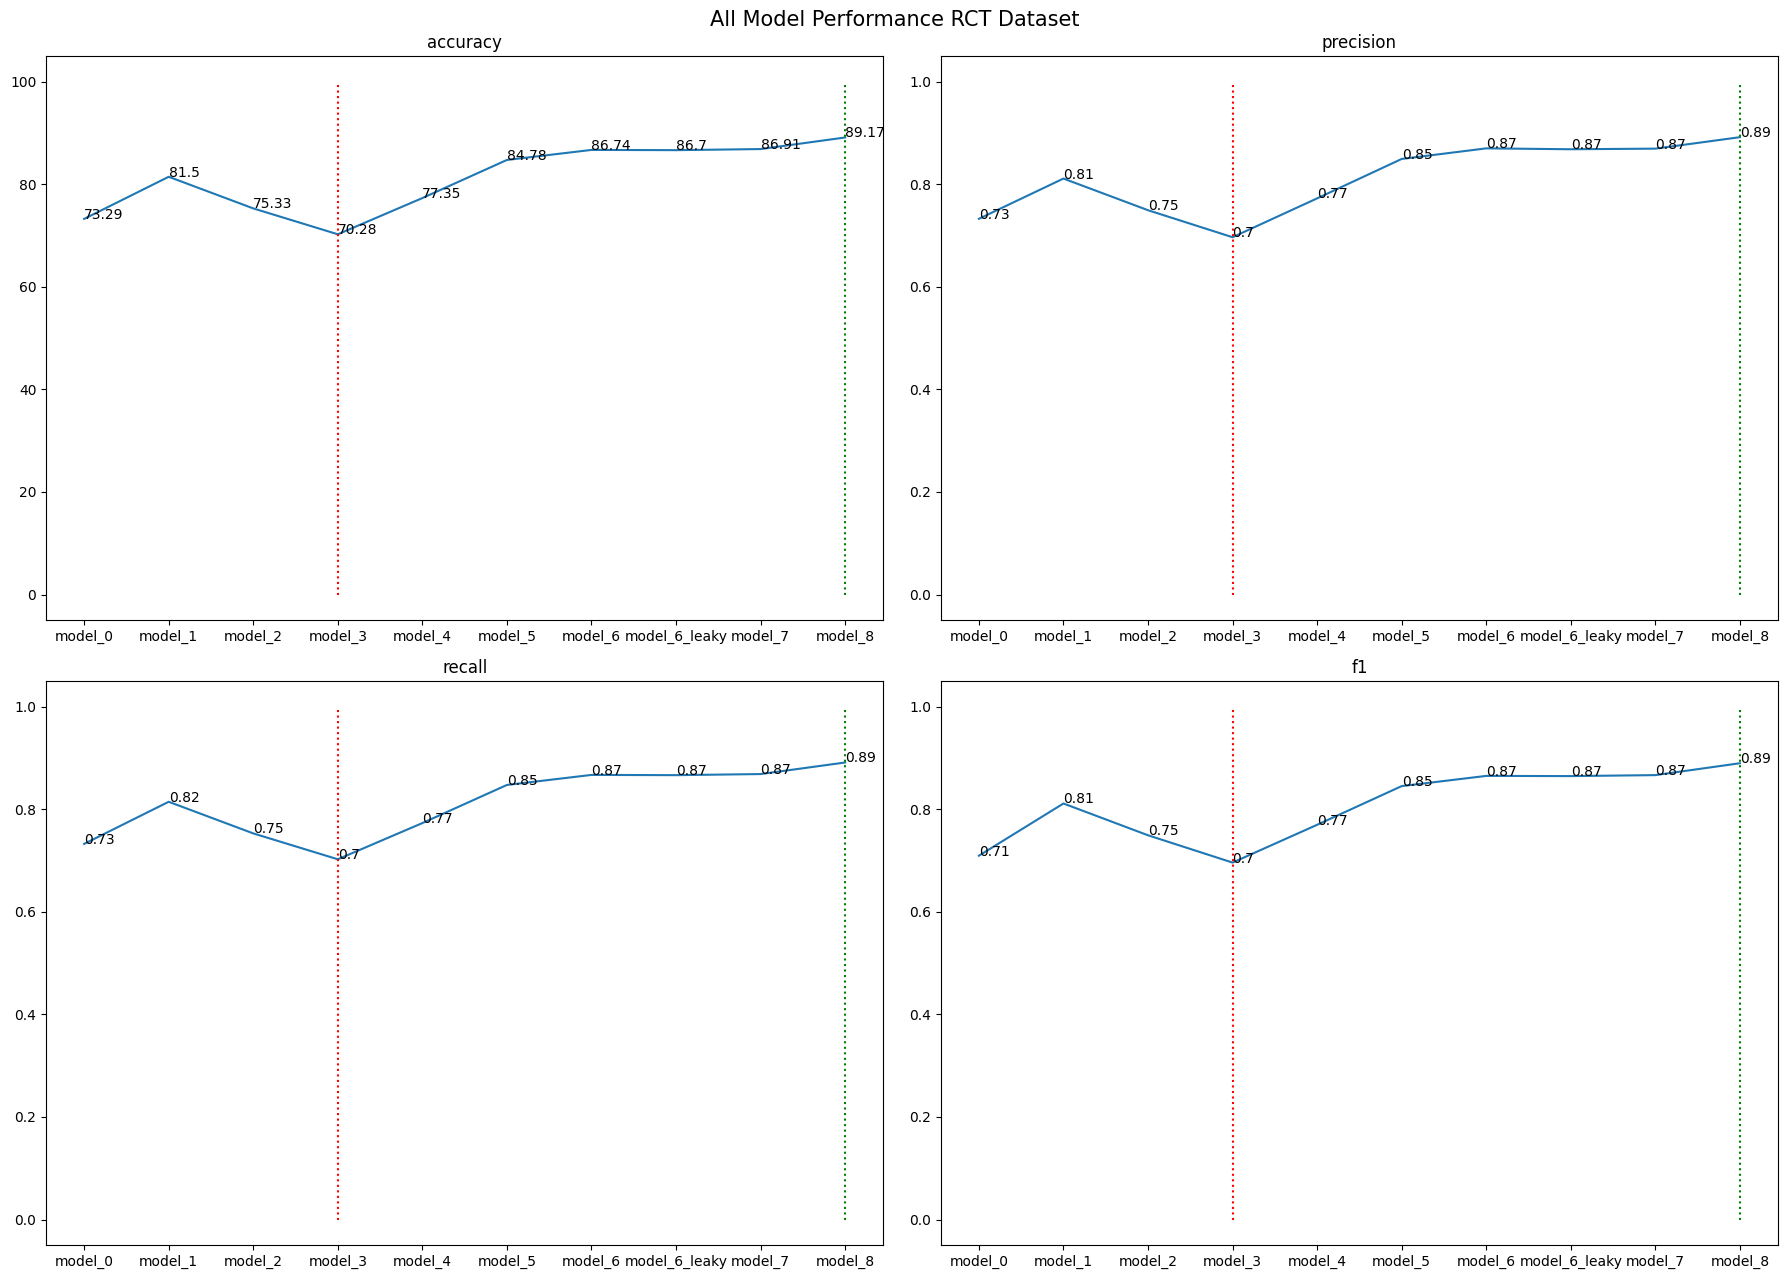

In [ ]:
fig = plt.figure(figsize=(18, 13))
for i, index in enumerate(scores.columns):
  plt.subplot(2, 2, 1 + i)
  plt.plot(scores[index])
  plt.title(index)
  if index == 'accuracy':
    plt.vlines(scores.index[scores[index].argmax()], 0, 100, color='green', linestyles='dotted')
    plt.vlines(scores.index[scores[index].argmin()], 0, 100, color='red', linestyles='dotted')
  else:
    plt.vlines(scores.index[scores[index].argmax()], 0, 1, color='green', linestyles='dotted')
    plt.vlines(scores.index[scores[index].argmin()], 0, 1, color='red', linestyles='dotted')
  for i in range(len(scores[index])):
    plt.annotate(np.round(scores[index][i], 2), (i, scores[index][i]), )
  # plt.annotate(scores[index], (index, scores[index]))


fig.suptitle('All Model Performance RCT Dataset', size=15)
fig.tight_layout()
plt.savefig(FIG_PATH + 'all_model_performance.png')
plt.show()

## Best Model: Model 8

In [ ]:
PATH = '/content/drive/MyDrive/ColabNotebooks/projects/SciDigest/'

In [ ]:
best_model = tf.keras.models.load_model(MODEL_PATH + 'model_8')

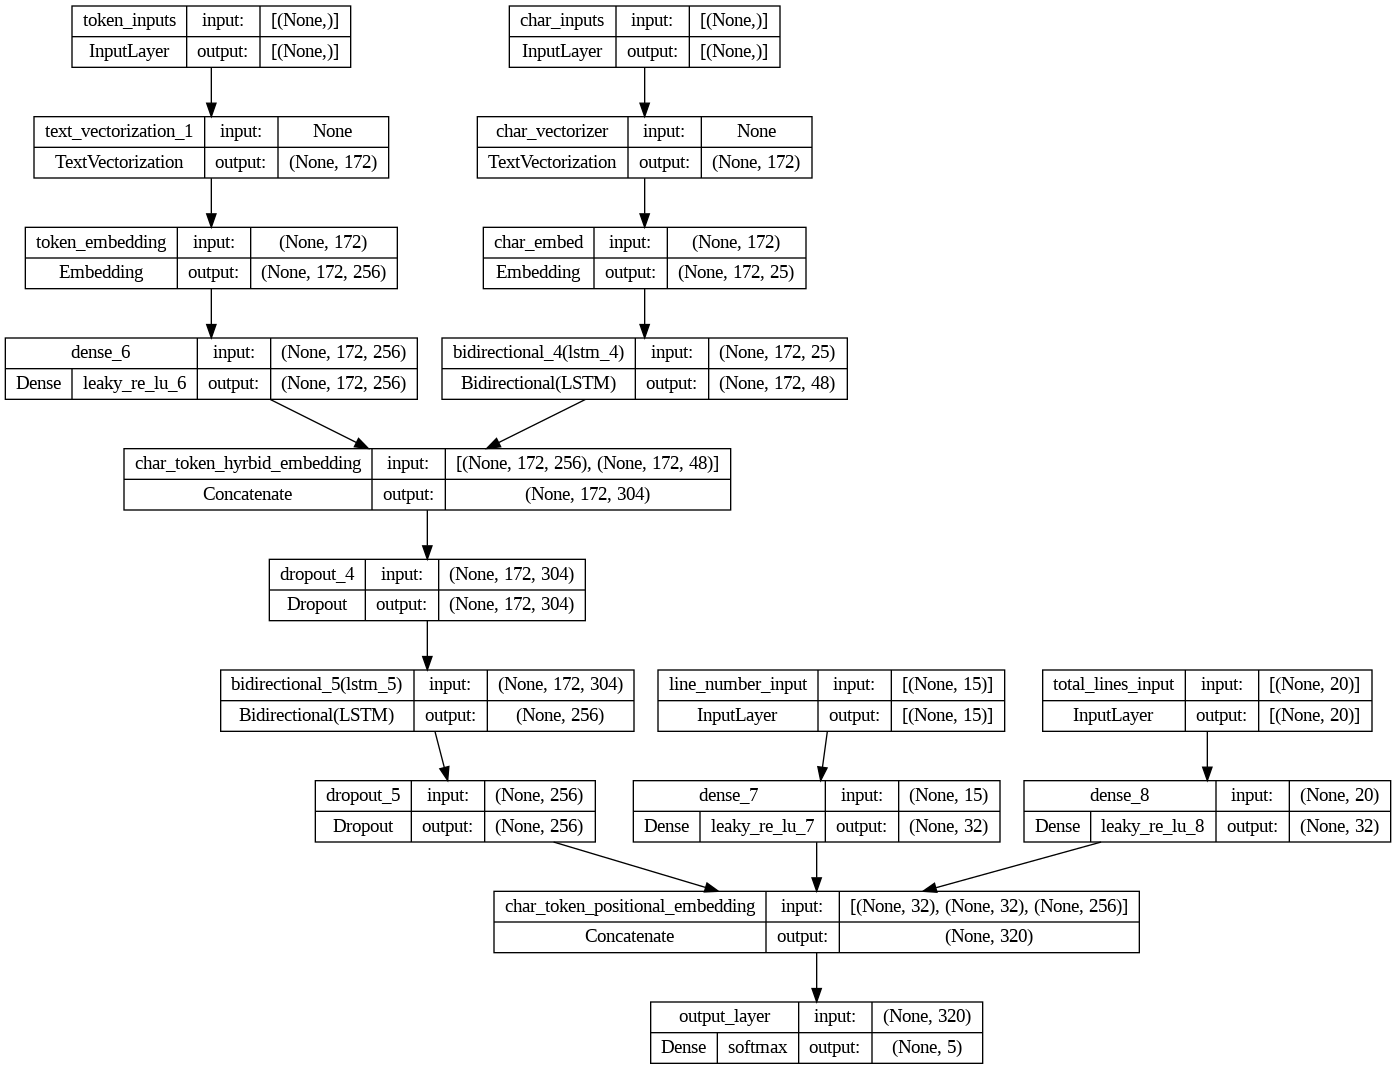

In [ ]:
plot_model(best_model, show_shapes=True, show_layer_activations=True, to_file= PATH + 'final_model_architecture.png')

In [ ]:
best_model.save(PATH + 'best_model')

In [ ]:
y_preds = predict_data(best_model, test_char_token_pos_dataset)
y_preds

In [ ]:
print(classification_report(test_le_labels, y_preds, digits=4, target_names=class_names))

              precision    recall  f1-score   support

  BACKGROUND     0.7298    0.8216    0.7730      2663
     METHODS     0.9323    0.8656    0.8977      4426
     RESULTS     0.9169    0.9506    0.9334      9751
 CONCLUSIONS     0.8288    0.6214    0.7103      2377
   OBJECTIVE     0.9083    0.9277    0.9179     10276

    accuracy                         0.8917     29493
   macro avg     0.8633    0.8374    0.8465     29493
weighted avg     0.8922    0.8917    0.8902     29493



In [ ]:
# classification report dictionary
cr_best_model = classification_report(test_le_labels, y_preds, digits=4, target_names=class_names, output_dict=True)

# Create empty dictionary
class_f1_scores = {}

# Loop through classifcation report dictionary items
for k, v in cr_best_model.items():
  if k == 'accuracy': # stop once we get to accuracy key
    break
  else:
    # Add class names and f1-scores to new dictionary
    class_f1_scores[k] = v['f1-score']


# turning it into a dataframe
best_f1_scores = pd.DataFrame({'class_names': list(class_f1_scores.keys()),
                               'f1-score':list(class_f1_scores.values())}).sort_values('f1-score', ascending=False)
best_f1_scores

,class_names,f1-score
2,RESULTS,0.933434
4,OBJECTIVE,0.917914
1,METHODS,0.897715
0,BACKGROUND,0.773008
3,CONCLUSIONS,0.710267


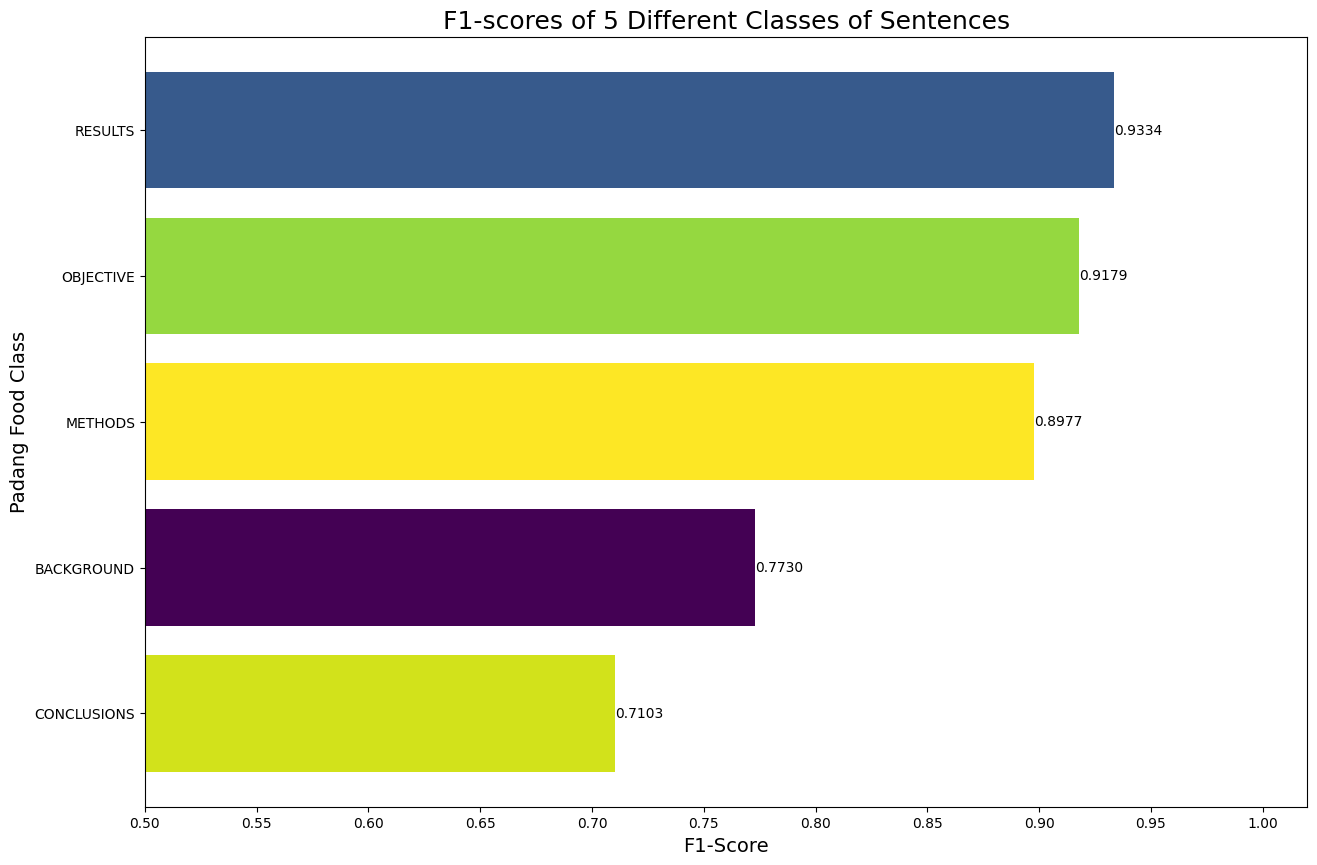

In [ ]:
# colors
class_f1_val = list(class_f1_scores.values())
denominator = max(class_f1_val) - min(class_f1_val)
scaled_data = [(datum-min(class_f1_val))/denominator for datum in class_f1_val]
colors = []
cmap = plt.colormaps['viridis']
for decimal in scaled_data:
  colors.append(cmap(decimal));


# plotting
fig, ax = plt.subplots(figsize=(15, 10))

scores = ax.barh(best_f1_scores['class_names'], best_f1_scores['f1-score'], color=colors)
ax.set_title('F1-scores of 5 Different Classes of Sentences', fontsize=18)
ax.bar_label(scores, fmt='%.4f')
ax.invert_yaxis()
ax.set_xlabel('F1-Score', fontsize=14)
ax.set_ylabel('Padang Food Class', fontsize=14)
ax.set_xlim(0.8, 1.02)
ax.set_xticks(np.arange(0.5, 1.05, 0.05))
# ax.set_yticks(fontsize=14)
plt.savefig(PATH + "scores_each_class.png")
plt.show()

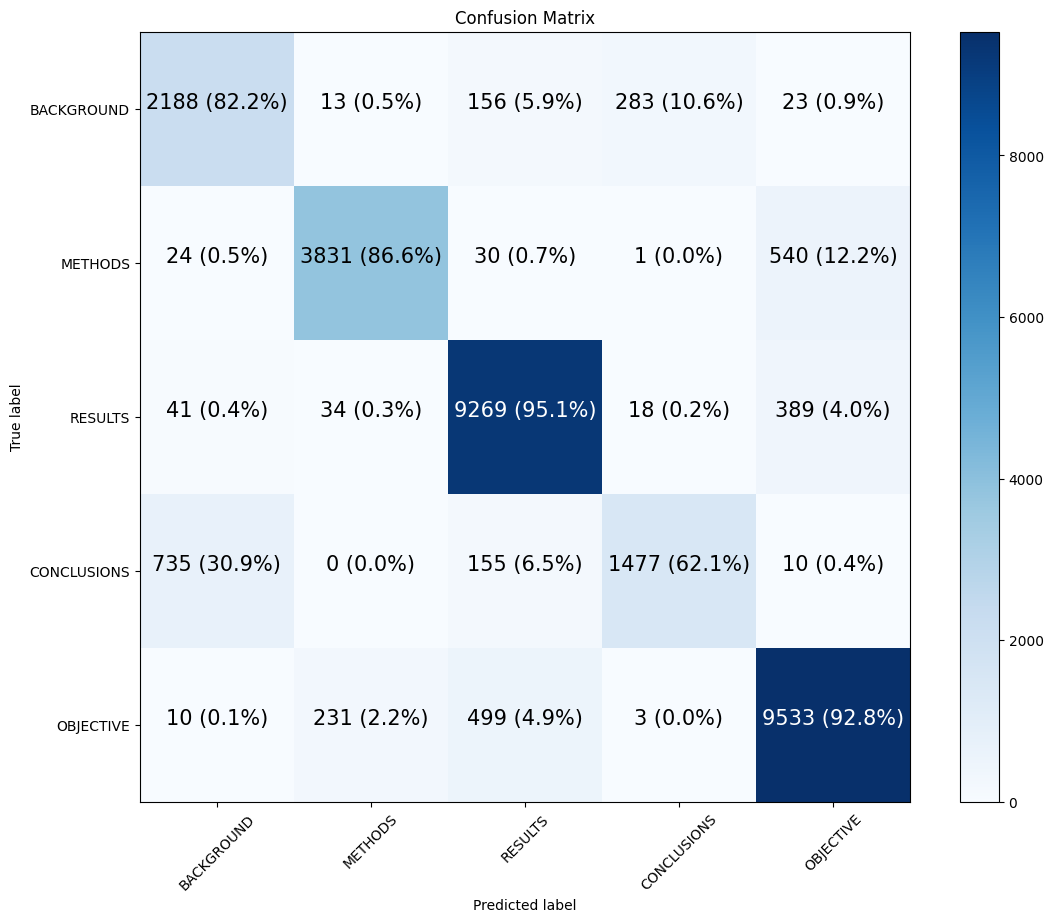

In [ ]:
cm = make_confusion_matrix(np.array(test_le_labels), y_preds.numpy(), list(class_names), figsize=(13, 10), norm=True)

In [ ]:
cm.savefig(PATH + "confusion_matrix.png")

In [ ]:
y_results = calculate_results(y_true=test_le_labels,
                                    y_pred=y_preds)
y_results

{'accuracy': 89.16692096429661,
 'precision': 0.8922472223989127,
 'recall': 0.8916692096429661,
 'f1': 0.8901948619423501}

In [ ]:
performance = pd.DataFrame(y_results, index=[0])
performance['accuracy'] = performance['accuracy'] / 100
performance

,accuracy,precision,recall,f1
0,0.891669,0.892247,0.891669,0.890195


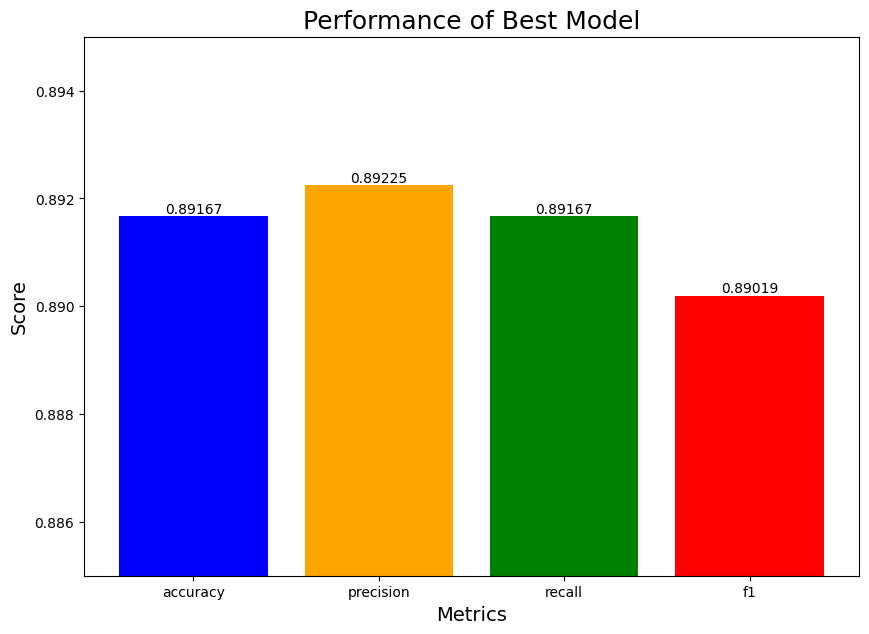

In [ ]:
color = ['blue', 'orange', 'green', 'red']

figure = plt.figure(figsize=(10, 7))
bar = plt.bar(performance.columns, performance.iloc[0], color=color)

plt.ylim(0.885, 0.895)
plt.title('Performance of Best Model', fontsize=18)
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.bar_label(bar, fmt='%.5f')
plt.xticks(['accuracy', 'precision', 'recall', 'f1'])

plt.savefig(PATH + "best_model_performance.png")
plt.show()

### Find most wrong

The most wrong predictions are samples where the model has made a prediction with a high probability but has gotten it wrong (the model's prediction disagreess with the ground truth label).

Looking at the most wrong predictions can give us valuable information on how to improve further models or fix the labels in our data.

In [ ]:
# Get list of class names of test predictions
test_pred_classes = [class_names[pred] for pred in y_preds]
test_pred_classes

['BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'RESULTS',
 'OBJECTIVE',
 'RESULTS',
 'RESULTS',
 'OBJECTIVE',
 'OBJECTIVE',
 'OBJECTIVE',
 'METHODS',
 'CONCLUSIONS',
 'RESULTS',
 'RESULTS',
 'OBJECTIVE',
 'OBJECTIVE',
 'OBJECTIVE',
 'METHODS',
 'CONCLUSIONS',
 'RESULTS',
 'OBJECTIVE',
 'OBJECTIVE',
 'OBJECTIVE',
 'OBJECTIVE',
 'OBJECTIVE',
 'RESULTS',
 'OBJECTIVE',
 'OBJECTIVE',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'BACKGROUND',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'OBJECTIVE',
 'OBJECTIVE',
 'OBJECTIVE',
 'OBJECTIVE',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'BACKGROUND',
 'CONCLUSIONS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'OBJECTIVE',
 'OBJECTIVE',
 'METHODS',
 'RESULTS',
 'OBJECTIVE',
 'CONCLUSIONS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'OBJECTIVE',
 'OBJECTIVE',
 'OBJECTIVE',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'CONCLUSIONS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'OBJECTIVE',
 'OBJECTIVE',
 'OBJECTIVE',
 'MET

Now Let's enrich the test_general DataFame with a few values:
* A `"prediction"` (string) column containing our model's prediction for a given sample.
* A `"pred_prob"` (float) column containing the model's maximum prediction probabiliy for a given sample.
* A `"correct"` (bool) column to indicate whether or not the model's prediction matches the sample's target label.

In [ ]:
test_general.head(5)

,target,text,line_number,total_lines
0,BACKGROUND,many pathogenic processes and diseases are the...,0,10
1,BACKGROUND,it was recently demonstrated that supraphysiol...,1,10
2,BACKGROUND,"in the present study , we examined the associa...",2,10
3,BACKGROUND,"in addition , we compared plasma levels of map...",3,10
4,METHODS,a total of @ mi patients and @ control persons...,4,10


In [ ]:
# Make predictions on the test dataset again to get the probabilities
test_pred_probs = best_model.predict(test_char_token_pos_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

922/922 [==============================] - 293s 318ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 2, 4, 2, 2, 4, 4, 4])>

In [ ]:
# Create prediction-enriched test dataframe
test_general["prediction"] = test_pred_classes # create column with test prediction class names
test_general["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_general["correct"] = test_general["prediction"] == test_general["target"] # create binary column for whether the prediction is right or not
test_general.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,many pathogenic processes and diseases are the...,0,10,BACKGROUND,0.678460,True
1,BACKGROUND,it was recently demonstrated that supraphysiol...,1,10,BACKGROUND,0.558975,True
2,BACKGROUND,"in the present study , we examined the associa...",2,10,BACKGROUND,0.411338,True
3,BACKGROUND,"in addition , we compared plasma levels of map...",3,10,RESULTS,0.622032,False
4,METHODS,a total of @ mi patients and @ control persons...,4,10,OBJECTIVE,0.640203,False
5,METHODS,plasma samples were obtained and analysed with...,5,10,RESULTS,0.794759,False
6,METHODS,the myocardial outcomes ( salvage index and fi...,6,10,RESULTS,0.468529,False
7,RESULTS,mi patients had @ % higher plasma levels of ma...,7,10,OBJECTIVE,0.875004,False
8,RESULTS,"however , neither salvage index ( spearman rho...",8,10,OBJECTIVE,0.851432,False
9,RESULTS,"likewise , masp-@ and masp-@ were elevated in ...",9,10,OBJECTIVE,0.803314,False


Now, let's sort it to find the most wrong

In [ ]:
# Find top 100 most wrong samples
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:100]
top_100_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
13009,METHODS,forty-four anovulatory women with pcos undergo...,4,14,RESULTS,0.923968,False
12945,METHODS,this study is a randomized controlled trial wi...,4,22,RESULTS,0.919331,False
10267,OBJECTIVE,to test the hypothesis that switching from l-m...,0,13,CONCLUSIONS,0.919201,False
6022,METHODS,a randomised controlled study .,2,16,RESULTS,0.918777,False
26441,METHODS,prospective randomized clinical trial .,3,21,RESULTS,0.916659,False
...,...,...,...,...,...,...,...
2896,OBJECTIVE,to compare the risk of cesarean wound disrupti...,0,15,CONCLUSIONS,0.897928,False
24599,METHODS,one thousand thirty-six child health care cent...,4,15,RESULTS,0.897905,False
27795,CONCLUSIONS,dialysis facility efforts to increase patient ...,15,15,METHODS,0.897681,False
6403,CONCLUSIONS,the study will contribute to a better understa...,12,12,METHODS,0.897639,False


In [ ]:
# Investigate top wrong preds
for row in top_100_wrong[0:10].itertuples(): # adjust indexes to view different samples
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: METHODS, Pred: RESULTS, Prob: 0.9239680171012878, Line number: 4, Total lines: 14

Text:
forty-four anovulatory women with pcos undergoing lod .

-----

Target: METHODS, Pred: RESULTS, Prob: 0.9193306565284729, Line number: 4, Total lines: 22

Text:
this study is a randomized controlled trial with three conditions : two treatment conditions and one waiting list control group .

-----

Target: OBJECTIVE, Pred: CONCLUSIONS, Prob: 0.9192011952400208, Line number: 0, Total lines: 13

Text:
to test the hypothesis that switching from l-methadone to d,l-methadone is associated with more frequent withdrawal symptoms and side-effects than switching from d,l-methadone to l-methadone .

-----

Target: METHODS, Pred: RESULTS, Prob: 0.9187766313552856, Line number: 2, Total lines: 16

Text:
a randomised controlled study .

-----

Target: METHODS, Pred: RESULTS, Prob: 0.9166586399078369, Line number: 3, Total lines: 21

Text:
prospective randomized clinical trial .

-----

Target: METHODS, P

## Conclusion

This is Paper 2's model:
![image](https://drive.google.com/uc?export=view&id=1237sz70ncTkzRxKoIufBSh3Q-xkUcuHt)

This is my implementation of the model:
![image](https://drive.google.com/uc?export=view&id=11XziiCR8e1CGwj_ecwCiuOJN_t_rvUcS)

Aside from the things that are not explained in the paper, and I decide on myself, here's a few changes:
1. My implementation of label optimization
2. Using Adam optimizer instead of SGD
3. Using a custom-trained embedding layer instead of GloVe

There are some other implementations I added/decided on my own since it wasn't specified in the paper.


The best model's F1-score is **0.890/89.0** which is **0.026/2.6** lower than the target of **91.6**. This model didn't succeed in reaching the goal. There are several things that can be improved with more time and computing power:
1. Adding some batch normalization layers
2. Adapting embedding layers on all the training sentences
3. Experimenting with the learning rate
4. Experiment with batch size.
